# Graph

In [195]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import networkx.algorithms.isomorphism as iso

In [364]:
def ErdosRenyi(n,p):
    A = np.random.rand(n,n)
    for i in range(n):
        A[i,i] = 0
        for j in range(i+1,n):
            A[i,j] = A[j,i]
    return (A<p)

def r_neighbors(v,A,r):
    n = A.shape[0]
    B = A + np.identity(n)
    neighbors = np.linalg.matrix_power(B,r)
    return [w for w in range(n) if neighbors[v,w]>0]

def neighbourhood(v,A,r):
    """returns the r-neighbourhood of v"""
    ngh = r_neighbors(v,A,r)
    return A[ngh,:][:,ngh]

def diameter(A): #nx.diameter(G)
    n = A.shape[0]
    B = np.zeros((n,n))
    for r in range(n):
        B += np.linalg.matrix_power(A,r)
        if np.all(B>0):
            return r
    return np.inf

def all_neighborhoods(A,r):
    n = A.shape[0]
    neighbors = np.linalg.matrix_power(A + np.identity(n),r)
    for i in range(n):
        neighbors[i,i] = 0
    neighbors = neighbors > 0
    
    nghs = []
    for v in range(n):
        v_ngh = [v]+np.nonzero(neighbors[v,:])[0].tolist()
        nghs.append(A[np.ix_(v_ngh,v_ngh)])
    return nghs

def convert_matrix_to_graph(nghs):
    graphs = []
    for ngh in nghs:
        g = nx.from_numpy_matrix(ngh)
        g.add_node(0, color = 'red')
        for v in range(1,len(g)):
            g.add_node(v, color = 'blue')
        graphs.append(g)
    return graphs

def check_isomorphic_nghs(nghs): #from a list of graphs with center, returns matrix is_isomorph
    n = len(nghs)
    is_isomorph = np.identity(n)
    nm = iso.categorical_node_match('color', 'red')
    for v in range(n):
        for w in range(v+1,n):
            G1, G2 = nghs[v], nghs[w]
            if nx.faster_could_be_isomorphic(G1, G2):
                if nx.is_isomorphic(G1, G2 , node_match = nm):
                    is_isomorph[v,w] = 1
                    is_isomorph[w,v] = 1
    return is_isomorph


def remove_small_components(graphs,nghs,r): 
    #returns a list of the nodes in small components
    #i.e. those who are identified after first step of reconstruction
    n = len(graphs)
    nm = iso.categorical_node_match('color', 'red')
    remaining = [i for i in range(n)]
    small_components = []
    
    for v in range(n):
        if v in remaining:
            if nx.eccentricity(graphs[v], 0) < r: # the neighborhood of v is a small component
                graphs_nested = convert_matrix_to_graph(all_neighborhoods(nghs[v],r))
                for graph_nested in graphs_nested:
                    corresponding_node = 0
                    for w in remaining:
                        if nx.fast_could_be_isomorphic(graph_nested, graphs[w]):
                            if nx.is_isomorphic(graph_nested, graphs[w] , node_match = nm):
                                corresponding_node = w #we have identified w as in the component of v
                                break
                    remaining.remove(corresponding_node)
                    small_components.append(corresponding_node)
    return (small_components, remaining)
        

In [365]:
n = 100
lamb = 2
lambs = 0.408 #Proxi: 1/lamb
A = ErdosRenyi(n, lamb/n)
r = int(np.log(n)/np.log(1/0.408))#

nghs = all_neighborhoods(A,1)
graphs = convert_matrix_to_graph(nghs)
is_isomorphic = check_isomorphic_nghs(graphs)
print(sum(is_isomorphic))
for k in range(2,r+1):
    nghs = all_neighborhoods(A,k)
    graphs = convert_matrix_to_graph(nghs)
    new_is_isomorphic = check_isomorphic_nghs(graphs)
    print(sum(is_isomorphic - new_is_isomorphic))
    is_isomorphic = new_is_isomorphic

[19. 24. 19. 31. 31. 31. 31. 10. 19. 19.  9. 31. 24. 24. 19. 10. 19. 19.
 19.  9. 31. 24. 24.  9. 19. 10. 31. 31. 31. 31. 24. 24. 19.  2. 31.  2.
  9. 19. 24. 10.  9. 10.  4. 19. 31. 24. 24. 31. 31. 24.  4. 24. 31. 24.
 31. 31. 19. 31. 31. 19. 31. 31. 10. 24. 24. 10. 10.  9. 19.  9. 31. 24.
 31. 24. 31. 31. 10.  9.  4. 24. 10. 24. 31. 19. 31. 24. 24. 24.  1.  9.
 31. 24. 19. 19. 19. 24. 31. 31.  4. 31.]
[16. 15. 18. 28. 28. 29. 28.  9. 18. 18.  0. 27. 15. 15. 18.  9. 16. 18.
 16.  0. 30. 20. 17.  0. 16.  9. 30. 28. 28. 30. 15. 17. 16.  1. 28.  1.
  0. 18. 15.  9.  0.  9.  2. 16. 30. 15. 15. 27. 30. 20.  3. 17. 27. 17.
 28. 30. 16. 30. 30. 18. 28. 29.  9. 22. 15.  9.  9.  0. 16.  0. 30. 22.
 30. 23. 28. 30.  9.  0.  2. 23.  9. 20. 28. 16. 27. 15. 17. 17.  0.  0.
 28. 17. 18. 18. 18. 20. 30. 28.  3. 30.]
[2. 6. 0. 2. 2. 1. 2. 0. 0. 0. 0. 3. 6. 8. 0. 0. 2. 0. 2. 0. 0. 2. 4. 0.
 2. 0. 0. 2. 2. 0. 7. 4. 2. 0. 2. 0. 0. 0. 6. 0. 0. 0. 1. 2. 0. 7. 8. 3.
 0. 3. 0. 4. 3. 4. 2. 0. 2. 0. 0. 0. 2. 

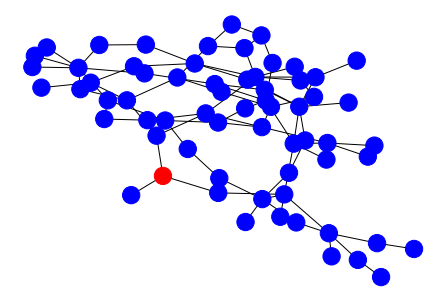

In [366]:
nx.draw(graphs[0], node_color = ['red']+['blue']*(len(graphs[0])-1))

74


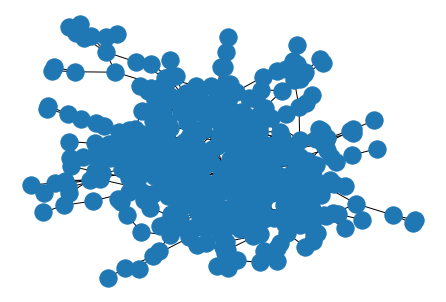

In [369]:
# drawing the graph once the small components have been removed

print(len(small_components))
G = nx.from_numpy_matrix(A)
for v in small_components:
    G.remove_node(v)
nx.draw(G)

In [466]:
################# Reconstruction Algorithm #####################

n = 500
lamb = 2
lambs = 0.408 #Proxi: 1/lamb
A = ErdosRenyi(n, lamb/n)
r = int(np.log(n)/np.log(1/0.408))#

### Stage 1: remove small components
print('Stage 1')

nghs = all_neighborhoods(A,r)
graphs = convert_matrix_to_graph(nghs)
small_components, remaining = remove_small_components(graphs,nghs,r)

G = nx.from_numpy_matrix(A)
for v in small_components:
    G.remove_node(v)
n_remain = len(remaining)
A_remain = A[np.ix_(remaining,remaining)]
G_remain = nx.from_numpy_matrix(A_remain)
print(A_remain.shape)

### Stage 2: identify isomorphic r-1 neighborhoods
print('Stage 2')

nghs_r1 = all_neighborhoods(A_remain,r-1)
graphs_r1 = convert_matrix_to_graph(nghs_r1)
is_isomorphic = check_isomorphic_nghs(graphs_r1)

for v in range(is_isomorphic.shape[0]):
    is_isomorphic[v,v] = 0
x, y = np.nonzero(is_isomorphic)
pb_nodes2 = sorted(set(x))
print(pb_nodes2)

### Stage 3: among these isomorphic r-1 neighborhoods, identify those who have different r neighborhoods
print('Stage 3')

nghs = all_neighborhoods(A_remain,r)
graphs = convert_matrix_to_graph(nghs)
nm = iso.categorical_node_match('color', 'red')
is_problematic = np.zeros((n_remain, n_remain))
for i in range(len(x)):
    if x[i] > y[i]:
        if not nx.is_isomorphic(graphs[x[i]], graphs[y[i]] , node_match = nm):
            is_problematic[x[i],y[i]] = 1
            is_problematic[y[i],x[i]] = 1
x, y = np.nonzero(is_problematic)
pb_nodes3 = sorted(set(x))
print(pb_nodes3)
            
### Stage 4: among these problematic neighborhoods, which ones are consitent with Massoulie reconstruction?
print('Stage 4')

pb_nodes4 = []
for v in pb_nodes3:
    similar_nodes = np.nonzero(is_problematic[v,:])[0]
    neighbors = [x for x in G_remain.neighbors(v)]
    if is_isomorphic[np.ix_(similar_nodes,neighbors)].sum() > 0:
        pb_nodes4.append(v)
print(pb_nodes4)

### Stage 5: looking at those who are at the edge of the graph
print('Stage 5')

edge_nodes = []
for v in range(is_isomorphic.shape[0]):
    if nx.diameter(graphs[v]) < 2*r:
        edge_nodes.append(v)
print(len(edge_nodes))
print([x for x in pb_nodes2 if x not in edge_nodes])
print([x for x in pb_nodes3 if x not in edge_nodes])
print([x for x in pb_nodes4 if x not in edge_nodes])

Stage 1
(394, 394)
Stage 2
[0, 5, 14, 24, 26, 38, 47, 48, 51, 59, 74, 77, 99, 105, 117, 129, 133, 143, 147, 153, 172, 177, 189, 190, 207, 213, 215, 220, 225, 236, 240, 241, 251, 276, 296, 302, 340, 343, 344, 367, 375, 391]
Stage 3
[]
Stage 4
[]
Stage 5
186
[]
[]
[]


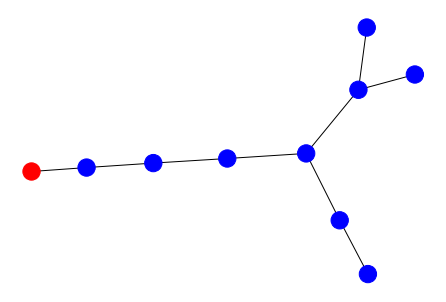

In [452]:
index = 178
nx.draw(graphs[index], node_color = ['red']+['blue']*(len(graphs[index])-1))

In [306]:
n = 1000
lamb = 2
lambs = 0.408 #Proxi: 1/lamb
A = ErdosRenyi(n, lamb/n)
r = int(np.log(n)/np.log(1/0.408))#
print("r attendu  : ",r)
print("diam vg0<10: ",nx.diameter(nx.from_numpy_matrix(neighbourhood(0,A,r))))
print("diametreth :",int(r+2*np.log(n)/np.log(lamb)))

r attendu  :  7
diam vg0<10:  3
diametreth : 26


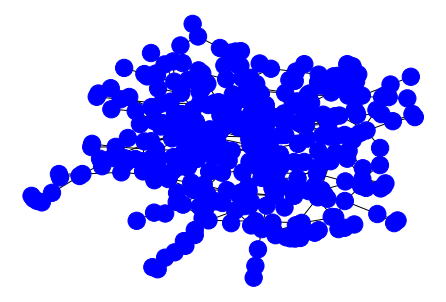

In [42]:
N = neighbourhood(0,A,r)
m = N.shape[0]
G = nx.from_numpy_matrix(neighbourhood(0,A,r))

nx.draw(G,node_color = (["red"]+["blue"]*(m-1)))

In [32]:
nx.diameter(G)

12

In [34]:
diameter(N)

12